# Метрики классификации

In [1]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt 
import seaborn as sns 

# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18})

from warnings import simplefilter
simplefilter('ignore')

## Ошибки I и II рода

Приведем пример.\
Для наглядности нарисуем график.

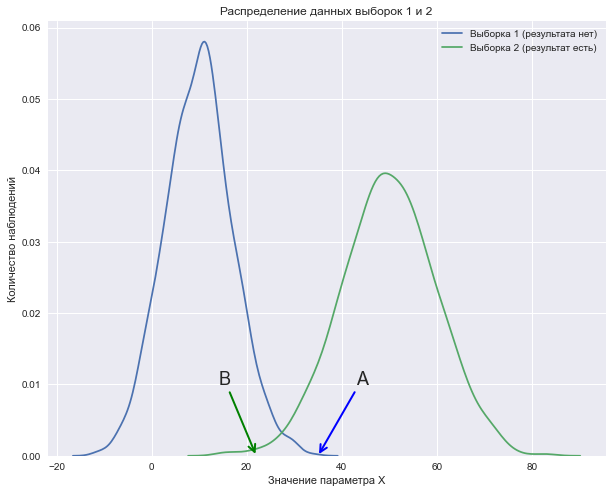

In [2]:
# сгенерируем датасет из двух нормальных распределений
random_data = pd.DataFrame({   
    'sample_1': np.random.normal(10, 7, 2000),
    'sample_2': np.random.normal(50, 10, 2000),
})

# фигура + координатная плоскость
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))

# название графика и подписи к осям
ax.set_title('Распределение данных выборок 1 и 2')
ax.set_xlabel('Значение параметра X')
ax.set_ylabel('Количество наблюдений')

# нарисуем точку А из выборки 1
a_x = 35
a_y = 0
plt.annotate(
    'A', 
    xy=(a_x, a_y), 
    xytext=(a_x + 8, a_y + 0.01),
    arrowprops={'arrowstyle': '->', 'linewidth': 2, 'color': 'blue'},
)

# нарисуем точку В из выборки 2
b_x = 22
b_y = 0
plt.annotate(
    'B', 
    xy=(b_x, b_y), 
    xytext=(b_x - 8, b_y + 0.01),
    arrowprops={'arrowstyle': '->', 'linewidth': 2, 'color': 'green'},
)

# графики плотности распределений выборок
sns.kdeplot(random_data['sample_1'], ax=ax, label ='Выборка 1 (результата нет)')
sns.kdeplot(random_data['sample_2'], ax=ax, label ='Выборка 2 (результат есть)')

# легенда
plt.legend()

Пусть у нас есть две выборки - "**Выборка 1**" и "**Выборка 2**".\
В первой выборке результат некоторого эксперимента (или исследования) отрицательный.\
Во второй выборке - положительный.

### Ошибка I рода

Пусть мы взяли точку **А**, которая на самом деле принадлежит распределению из **выборки 1**.\
Но мы взяли такое **p-value**, что считаем, что **A** принадлежит **2-й выборке**.\
То есть, мы считаем, что для данного элемента результат есть, в то время как его нет.\
Тогда мы совершаем **ошибку I рода**.\
То есть, имеем **ложноположительное** предположение.

То есть, имеем точку **А**
- $H_0$: Нулевая гипотеза - эффекта для А нет, мы находимся в пределах выборки 1
- $H_1$: Альтернативная гипотеза - эффект для А есть, мы находимся в пределах выборки 2.

С учетом выбранного p-value делаем вывод, что точка А принадлежит выборке 2, то есть верна гипотеза $H_1$.\
А верна на самом деле гипотеза $H_0$.\
Это **ошибка I рода**.

### Ошибка II рода

Пусть у нас есть точка **В**, которая на самом деле принадлежит **выборке 2**.\
Но мы взяли такое **p-value**, по которому рассчитываем, что точка **В** принадлежит **выборке 1**.\
То есть, мы предполагаем, что для В эффекта нет, в то время, как он на самом деле есть.
Тогда мы совершаем **ошибку II рода**.
То есть делаем **ложноотрицательное** предположение.

Иначе говоря, имеем точку **В**.
- $H_0$: Нулевая гипотеза - эффекта для B нет, мы находимся в пределах выборки 1
- $H_1$: Альтернативная гипотеза - эффект для B есть, мы находимся в пределах выборки 2.

С учетом выбранного p-value делаем вывод, что точка B принадлежит выборке 1, то есть верна гипотеза $H_0$.\
А верна на самом деле гипотеза $H_1$.\
Это **ошибка II рода**.

## Матрица ошибок (confusion matrix)

Для начала загрузим таблицу с данными и сделаем для нее предсказание целевого бинарного признака.

In [3]:
# Для примера возьмем данные о диабете
diabetes_data_full = fetch_openml(name='diabetes')
diabetes_data = diabetes_data_full['frame']

# Заменим в целевом признаке значение tested_positive на 1, а tested_negative на 0
diabetes_data['class'] = diabetes_data['class'].apply(lambda x: 1 if x == 'tested_positive' else 0)
diabetes_data['class'] = diabetes_data['class'].astype(int)

diabetes_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


In [4]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    float64
 1   plas    768 non-null    float64
 2   pres    768 non-null    float64
 3   skin    768 non-null    float64
 4   insu    768 non-null    float64
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    float64
 8   class   768 non-null    int32  
dtypes: float64(8), int32(1)
memory usage: 51.1 KB


In [5]:
# признаки
X = diabetes_data.drop(['class'], axis=1)
# целевой признак
y = diabetes_data['class']

# разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [6]:
# создаём объект класса LogisticRegression
logistic_regression_model = LogisticRegression(random_state=42, max_iter=1000)

# обучаем модель
logistic_regression_model.fit(X_train, y_train)

# сделаем предсказание для тренировочной выборки
y_train_pred = logistic_regression_model.predict(X_train)
# сделаем предсказание для тестовой выборки
y_test_pred = logistic_regression_model.predict(X_test)

Матрицу ошибок можно построить с помощью функции [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) модуля `sklearn.metrics`.

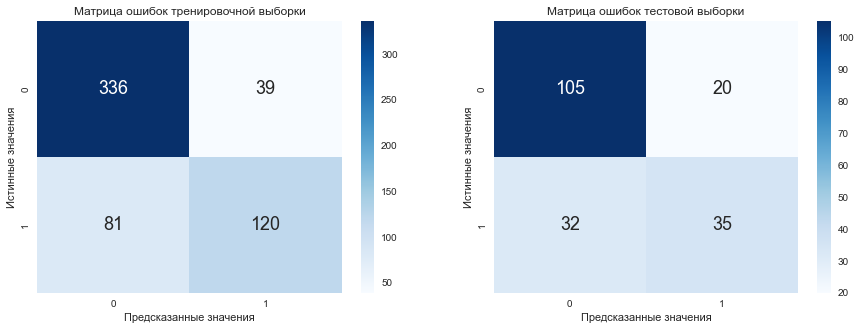

In [7]:
# матрица ошибок для тренировочной выборки
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
# матрица ошибок для тестовой выборки
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)

# визуализируем матрицы ошибок
# фигура + 2 координатные плоскости
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 

# тепловая карта для матрицы ошибок тренировочной выборки
sns.heatmap(confusion_matrix_train, annot=True, fmt='', ax=axes[0], cmap='Blues')

# название графика и подписи осей
axes[0].set_title('Матрица ошибок тренировочной выборки')
axes[0].set_xlabel('Предсказанные значения')
axes[0].set_ylabel('Истинные значения')

# тепловая карта для матрицы ошибок тестовой выборки
sns.heatmap(confusion_matrix_test, annot=True, fmt='', ax=axes[1], cmap='Blues')

# название графика и подписи осей
axes[1].set_title('Матрица ошибок тестовой выборки')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения');

**Матрица ошибок содержит следующие значения:**

<table>
<tr>
<th colspan="2" rowspan="2"></th><th colspan="2">Предсказанные значения</th>
</tr>
<tr>
<th>0</th>
<th>1</th>
</tr>
<tr>
<th rowspan="2" style="writing-mode: vertical-lr">Истинные значения</th>
<th>0</th>
<td style="background: PaleGreen">
Кол-во верно предсказаных 0<br />
True Nenative (<b>TN</b>)<br />
Нет ошибок
</td>
<td style="background: Pink">
Кол-во неверно предсказаных 1<br />
False Positive (<b>FP</b>)<br />
Кол-во ошибок I рода
</td>
</tr>
<tr>
<th>1</th>
<td style="background: Pink">
Кол-во неверно предсказаных 0<br />
False Negative (<b>FN</b>)<br />
Кол-во ошибок II рода
</td>
<td style="background: PaleGreen">
Кол-во верно предсказаных 1<br />
True Positive (<b>TP</b>)<br />
Нет ошибок
</td>
</tr>
</table>

**На основе матрицы ошибок строятся метрики классификации.**

## Accuracy (достоверность/аккуратность) 

> **Accuracy (достоверность/аккуратность)** — доля правильных ответов модели среди всех ответов. \
Правильные ответы — это истинно положительные (True Positive) и истинно отрицательные ответы (True Negative):
> 
> $$ accuracy = \frac{TP + TN}{TP + TN + FN + FP} = \frac{правильно\ предсказанные\ ответы}{все\ ответы} $$

**Интерпретация**: как много (в долях) модель угадала ответов.

Метрика изменяется в диапазоне от 0 до 1. \
Чем ближе значение к 1, тем больше ответов модель «угадала».

**Можно использовать только, когда классы сбалансированы.**

Если классы не сбалансированы, то если модель будет всегда предсказывать значение для превалирующего класса,\
то результат метрики может быть лучше, чем если бы модель пыталась именно предсказывать значения.

In [8]:
# рассчитываем accuracy
print(f'Accuracy train: {metrics.accuracy_score(y_train, y_train_pred)}')
print(f'Accuracy test: {metrics.accuracy_score(y_test, y_test_pred)}')

Accuracy train: 0.7916666666666666
Accuracy test: 0.7291666666666666


## Precision (точность)

> **Precision (точность)**, или **PPV (Positive Predictive Value)** — \
это доля объектов, которые действительно являются положительными, \
по отношению ко всем объектам, названным моделью положительными.
> $$ precision = \frac{TP}{TP+FP} = \frac{верно\ предсказанные\ 1}{все\ значения\ которые\ модель\ предсказала\ как\ 1} $$

Метрика также изменяется от 0 до 1.

**Интерпретация**: способность отделить класс 1 от класса 0. \
Чем больше precision, тем меньше ложных попаданий. 

**Чем ближе precision к 1, тем меньше вероятность модели допустить ошибку I рода**.

In [9]:
# рассчитываем precision
print(f'Precision train: {metrics.precision_score(y_train, y_train_pred)}')
print(f'Precision test: {metrics.precision_score(y_test, y_test_pred)}')

Precision train: 0.7547169811320755
Precision test: 0.6363636363636364


## Recall (полнота)

> **Recall (полнота)**, или **TPR (True Positive Rate)** — это доля объектов, \
названных классификатором положительными, \
по отношению ко всем объектам положительного класса.
> $$ recall = \frac{TP}{TP + FN} = \frac{верно\ предсказанные\ 1}{все\ истинные\ 1} $$

Метрика изменяется от 0 до 1.

**Интерпретация**: способность модели обнаруживать класс 1 вообще, то есть охват класса 1. \
Метрика зависит от количества ложноотрицательных срабатываний.

**Чем ближе recall к 1, тем меньше вероятность модели допустить ошибку II рода.**

Метрики **precision** и **recall** не зависят от сбалансированности классов \
и в совокупности дают довольно исчерпывающее представление о классификаторе. \
Однако на практике часто бывает так, что \
**увеличение одной из метрик может привести к уменьшению другой**.

In [10]:
# рассчитываем recall
print(f'Recall train: {metrics.recall_score(y_train, y_train_pred)}')
print(f'Recall test: {metrics.recall_score(y_test, y_test_pred)}')

Recall train: 0.5970149253731343
Recall test: 0.5223880597014925


## F-мера

> $F_{\beta}$ (**F-мера**) — это **взвешенное среднее гармоническое** между precision и recall:
> $$ F_{\beta} = (1+\beta^{2})\frac{precision \cdot recall}{(\beta^{2} precision) + recall}, $$
> где $\beta$ — это вес precision в метрике: чем больше $\beta$, тем больше вклад.

В частном случае, когда $\beta=1$, мы получаем равный вклад для precision и recall, \
а формула будет выражать простое среднее гармоническое, \
или метрику $F_{1}$ ($F_{1}$-мера):

$$ F_{1} = 2\frac{precision \cdot recall}{precision + recall} $$

Метрика равна своему максимуму (1), если и precision, и recall равны 1 \
(то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). \
Но если хотя бы одна из метрик будет близка к 0, то и $F_{1}$ будет близка к 0. 

$F_{1}$ используется в задачах, где необходимо выбрать модель, которая балансирует между precision и recall.

In [11]:
# рассчитываем F1-меру
print(f'F1 score train: {metrics.f1_score(y_train, y_train_pred)}')
print(f'F1 score test: {metrics.f1_score(y_test, y_test_pred)}')

F1 score train: 0.6666666666666666
F1 score test: 0.5737704918032788


> **Примечание**. все вышеприведенные рассуждения по отношению к precision, recall и $F$-мере, \
относятся только к классу 1, так как эти метрики по умолчанию считаются для класса 1.
>
> Если по каким-то причинам необходимо рассчитать precision, recall и $F$-меру для класса 0, \
для этого можно сделать перекодировку классов — поменять их обозначения местами \
или (при расчёте метрик с помощью библиотеки sklearn) изменить значение параметра `pos_label` на `0`.

Функция `classification_report()` из модуля `metrics` возвращает отчёт обо всех метриках классификации:

In [12]:
print('Metrics train\n', metrics.classification_report(y_train, y_train_pred))
print('')
print('Metrics test\n', metrics.classification_report(y_test, y_test_pred))

Metrics train
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       375
           1       0.75      0.60      0.67       201

    accuracy                           0.79       576
   macro avg       0.78      0.75      0.76       576
weighted avg       0.79      0.79      0.79       576


Metrics test
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       125
           1       0.64      0.52      0.57        67

    accuracy                           0.73       192
   macro avg       0.70      0.68      0.69       192
weighted avg       0.72      0.73      0.72       192



**В отчете отображается следующая информация:**

1. В первой части таблицы отображаются метрики **precision**, **recall** и **f1-score**, \
рассчитанные для каждого класса в отдельности. \
Столбец **support** — это количество объектов каждого из классов.

2. Во второй части таблицы отображена общая метрика **accuracy**. 

3. Далее идёт строка **macro avg** — это среднее значение метрики между классами 1 и 0. \
Например, значение в строке **macro avg** и столбце **recall = (0.84 + 0.52)/2=0.68**.

4. Последняя строка **weighted avg** — это средневзвешенное значение метрики между классами 1 и 0. \
Вес каждого класса определяется на основе доли объекта i-ого класса в выборке. \
Например, для случая двух классов метрика будет рассчитываться по формуле:
$$ score_{weighted-avg} = \frac{n_{class_0}}{n} score_{class_0} + \frac{n_{class_1}}{n} score_{class_1} $$
где $n_{class_0}$ и $n_{class_1}$ — количество наблюдений класса 0 и 1 соответственно, \
$n$ — общее количество наблюдений в данных.

В отчёте `classification_report()` рассчитаны метрики и для класса 0.